## Random Search and Basics of Gym

In [1]:
import gym
import os
import sys
from gym import wrappers
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDRegressor
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import tensorflow as tf

In [2]:
gym.envs.register(
    id='CartPole-v2',
    entry_point='gym.envs.classic_control:CartPoleEnv',
    tags={'wrapper_config.TimeLimit.max_episode_steps': 10000},
    reward_threshold=10000.0,
)
env = gym.make('CartPole-v2')

In [3]:
#Random Actions
done = False
c = 0
env.reset()
while not done:
    c+=1
    obser,r,done,_ = env.step(env.action_space.sample())
print(c)

17


In [5]:
#Random Linear Search
def get_action(s,w):
    return 1 if s.dot(w) > 0 else 0

def play_one_episode(env,params,render = False):
    observation = env.reset()
    done = False
    t = 0
    while not done and t < 10000:
        if render == True:
            env.render()
        t+=1
        action = get_action(observation,params)
        observation,reward,done,info = env.step(action)
    
    #Returning the number of steps
    return t

def play_multiple_episodes(env,T,params,render=False):
    episode_lengths = np.empty(T)
    
    for i in range(T):
        episode_lengths[i] = play_one_episode(env,params,render=render)
        
    avg = episode_lengths.mean()
    print("AVG: ",avg)
    return avg


def random_search(env):
    
    episode_lengths = []
    best = 0
    params = None
    for t in range(100):
        new_params = np.random.random(4)*2-1
        avg_length = play_multiple_episodes(env,100,new_params)
        episode_lengths.append(avg_length)
        
        if avg_length>best:
            best=avg_length
            params=new_params
            
    return episode_lengths,params


In [10]:
ep,parameters = random_search(env)

AVG:  9.61
AVG:  100.45
AVG:  83.67
AVG:  56.29
AVG:  9.05
AVG:  61.94
AVG:  82.63
AVG:  137.76
AVG:  9.5
AVG:  37.6
AVG:  130.44
AVG:  9.2
AVG:  83.57
AVG:  9.01
AVG:  200.0
AVG:  8.7
AVG:  9.13
AVG:  200.0
AVG:  9.07
AVG:  112.36
AVG:  82.23
AVG:  8.95
AVG:  9.13
AVG:  8.87
AVG:  9.1
AVG:  9.35
AVG:  35.02
AVG:  9.58
AVG:  9.73
AVG:  76.48
AVG:  78.98
AVG:  114.62
AVG:  9.43
AVG:  75.68
AVG:  154.66
AVG:  34.51
AVG:  89.97
AVG:  14.39
AVG:  145.65
AVG:  9.11
AVG:  25.35
AVG:  9.37
AVG:  103.66
AVG:  9.17
AVG:  51.73
AVG:  9.17
AVG:  9.46
AVG:  184.29
AVG:  70.0
AVG:  69.11
AVG:  9.14
AVG:  9.01
AVG:  9.22
AVG:  129.29
AVG:  36.16
AVG:  9.69
AVG:  30.63
AVG:  9.5
AVG:  8.97
AVG:  198.62
AVG:  9.59
AVG:  9.61
AVG:  9.8
AVG:  23.95
AVG:  50.32
AVG:  95.2
AVG:  9.59
AVG:  9.06
AVG:  9.09
AVG:  34.49
AVG:  63.31
AVG:  29.63
AVG:  9.68
AVG:  9.31
AVG:  9.61
AVG:  9.93
AVG:  9.16
AVG:  118.22
AVG:  109.44
AVG:  9.6
AVG:  81.21
AVG:  86.64
AVG:  93.48
AVG:  200.0
AVG:  9.13
AVG:  9.09
AVG:  

In [11]:
env = gym.make('CartPole-v0')
print(play_one_episode(env,parameters,render=True))
env.close()

200


In [12]:
env.close()

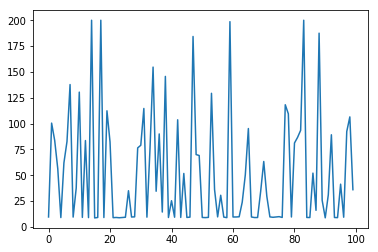

In [13]:
plt.plot(ep)
plt.show()

## Q-Learning with Bins

In [51]:
def build_state(features):
    '''[1,2,3,4,5]->12345'''
    return int("".join(map(lambda feature: str(int(feature)),features)))
def to_bin(value,bins):
    return np.digitize(x=[value], bins=bins)[0]

In [52]:
##TESTING THE ACTUAL VALUES OF BINS
#Random Actions


max_position = []
min_position = []
max_angle = []
min_angle = []
max_cvel = []
min_cvel= []
max_pvel = []
min_pvel = []
for _ in range(10000):
    done = False
    obs_list = []
    obser = env.reset()
    while not done:
        params = np.random.random(4)*2-1
        action = get_action(obser,params)
        obser,r,done,_ = env.step(action)
        obs_list.append(obser)


    obs_list = np.array(obs_list)
    obs_list = obs_list.transpose()
    
    max_position.append(max(obs_list[0]))
    min_position.append(min(obs_list[0]))
    max_cvel.append(max(obs_list[1]))
    min_cvel.append(min(obs_list[1]))
    max_angle.append(max(obs_list[2]))
    min_angle.append(min(obs_list[2]))
    max_pvel.append(max(obs_list[3]))
    min_pvel.append(min(obs_list[3]))


In [53]:
print(max(max_position))
print(min(min_position))
print()
print(max(max_cvel))
print(min(min_cvel))
print()
print(max(max_angle))
print(min(min_angle))
print()
print(max(max_pvel))
print(min(min_pvel))

1.37876666658
-2.12947528378

2.68059512751
-2.99306914338

0.271044559846
-0.262625082673

3.35006174376
-3.13374072358


In [54]:
#State shape : [position,velocity,angle,bins]

class FeatureTransformer:
    def __init__(self):
        #From the above observations
        #9 Divides = 10 Bins
        self.cart_position_bins = np.linspace(-2.4,2.4,9)
        self.cart_velocity_bins = np.linspace(3.2,-3.2,9)
        self.pole_angle_bins = np.linspace(-0.3,0.3,9)
        self.pole_velocity_bins = np.linspace(-3.5,3.5,9)
        
    def transform(self,observation):
        cart_pos,cart_vel,pole_angle,pole_vel = observation
        return build_state([
            to_bin(cart_pos, self.cart_position_bins),
            to_bin(cart_vel, self.cart_velocity_bins),
            to_bin(pole_angle, self.pole_angle_bins),
            to_bin(pole_vel, self.pole_velocity_bins)
        ])
    

In [55]:
class Model:
    def __init__(self, env, feature_transformer):
        self.env = env
        self.feature_transformer = feature_transformer
        #Since we have 10 bins for each 
        num_states = 10**env.observation_space.shape[0]
        num_actions = env.action_space.n
        #Defining the value function
        self.Q = np.random.uniform(low=-1,high=1,size=(num_states,num_actions))
        
    def predict(self,s):
        x = self.feature_transformer.transform(s)
        #Returns the Q value of actions at that state
        return self.Q[x]
    
    def update(self, s, a, G):
        #Getting the state's bin
        x = self.feature_transformer.transform(s)
        
        #Apply the Q learning function here
        # Q = Q + alpha*(R+gamma*max(Q')-Q)
        self.Q[x,a] += 10e-3*(G - self.Q[x,a])
        
    def sample_action(self,s,eps):
        #Going epsilon greedy
        if np.random.random()<eps:
            #Random Action
            return self.env.action_space.sample()
        else:
            #Model's best action
            p = self.predict(s)
            return np.argmax(p)
        

In [63]:
def play_one(model, eps, gamma):
    observation = env.reset()
    done = False
    totalreward = 0
    
    iters = 0 
    
    while not done and iters < 10000:
        action = model.sample_action(observation,eps)
        prev_observation = observation
        observation,reward,done,_ = env.step(action)
        
        totalreward += reward
        
        if done and iters<199:
            #High negative reward for falling before 199
            reward = -300
            
        #Calculating returns according to the 
        G = reward + gamma*np.max(model.predict(observation))
        model.update(prev_observation,action,G)
        
        iters += 1
        
    return totalreward



In [64]:
def plot_running_avg(totalreward):
    N = len(totalreward)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalreward[max(0,t-100):(t+1)].mean()
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


episode: 0 total_reward: 17.0 eps: inf
episode: 100 total_reward: 11.0 eps: 0.1
episode: 200 total_reward: 39.0 eps: 0.0707106781187
episode: 300 total_reward: 77.0 eps: 0.057735026919
episode: 400 total_reward: 87.0 eps: 0.05
episode: 500 total_reward: 42.0 eps: 0.04472135955
episode: 600 total_reward: 139.0 eps: 0.0408248290464
episode: 700 total_reward: 70.0 eps: 0.0377964473009
episode: 800 total_reward: 121.0 eps: 0.0353553390593
episode: 900 total_reward: 118.0 eps: 0.0333333333333
episode: 1000 total_reward: 236.0 eps: 0.0316227766017
episode: 1100 total_reward: 30.0 eps: 0.0301511344578
episode: 1200 total_reward: 221.0 eps: 0.0288675134595
episode: 1300 total_reward: 159.0 eps: 0.0277350098113
episode: 1400 total_reward: 179.0 eps: 0.0267261241912
episode: 1500 total_reward: 150.0 eps: 0.0258198889747
episode: 1600 total_reward: 201.0 eps: 0.025
episode: 1700 total_reward: 75.0 eps: 0.0242535625036
episode: 1800 total_reward: 196.0 eps: 0.0235702260396
episode: 1900 total_rewa

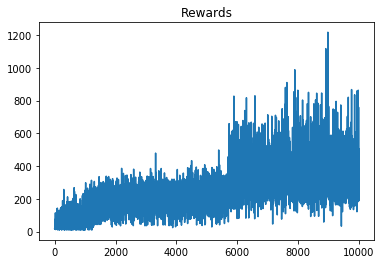

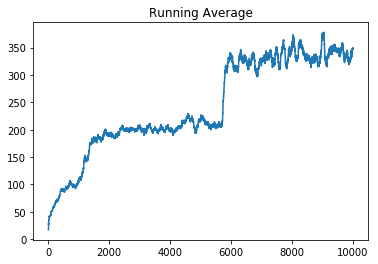

In [78]:
env = gym.make("CartPole-v2")
ft = FeatureTransformer()
model = Model(env,ft)
gamma = 0.9

filename = "qlearning"
monitor_dir ="./" + filename + "_" + str(datetime.now().date())
if monitor_dir[2:] not in os.listdir():
    os.mkdir(monitor_dir)  
env = wrappers.Monitor(env,monitor_dir)

N=10000
totalrewards = np.empty(N)
for n in range(N):
    eps = 1.0/np.sqrt(n)
    totalreward = play_one(model,eps,gamma)
    totalrewards[n] = totalreward
    if n%100==0:
        print("episode:",n, "total_reward:", totalreward, "eps:",eps)
print("avg rewards for last 100 episodes:", totalrewards[-100:].mean())
print("total steps:", totalrewards.sum())

plt.plot(totalrewards)
plt.title("Rewards")
plt.show()
plot_running_avg(totalrewards)

In [ ]:
env = gym.make("CartPole-v2")
filename = "qlearning_result"
monitor_dir ="./" + filename + "_" + str(datetime.now().date())
if monitor_dir[2:] not in os.listdir():
    os.mkdir(monitor_dir)
env = wrappers.Monitor(env,monitor_dir,force=True)
play_one(model,eps=0,gamma = 0.9)
env.close()

## Mountain Car with RBF network

In [5]:
class FeatureTransformer:
    def __init__(self,env):
        #Getting random 10000 samples for the state space for the dummy
        observation_example = np.array([env.observation_space.sample() for x in range(10000)])
        #Scaling the observation space
        scaler = StandardScaler()
        scaler.fit(observation_example)
        
        #Creating the Union of features with different parzen's windows
        featurizer = FeatureUnion([
            ("kernel1",RBFSampler(gamma=5.0, n_components=500)),
            ("kernel2",RBFSampler(gamma=2.0, n_components=500)),
            ("kernel3",RBFSampler(gamma=1.0, n_components=500)),
            ("kernel4",RBFSampler(gamma=0.5, n_components=500))
        ])
        
        
        #Fitting the state-to-feature converter
        featurizer.fit(scaler.transform(observation_example))
        
        self.scaler = scaler
        self.featurizer = featurizer
    
    def transform(self,observations):
        scaled = self.scaler.transform(observations)
        return self.featurizer.transform(scaled)
    

class Model:
    
    def __init__(self, env, feature_transformer, learning_rate):
        self.env = env
        #This will be a collection of multiple models, one for each action
        self.models = []
        self.feature_transformer = feature_transformer
        
        for i in range(env.action_space.n):
            model = SGDRegressor(learning_rate=learning_rate)
            #Doing a random fit to get the first set of random actions
            model.partial_fit(self.feature_transformer.transform([env.reset()]),[0])
            self.models.append(model)
            
    def predict(self,s):
        '''To transform a state and get a prediction form the model'''
        X = self.feature_transformer.transform([s])
        assert(len(X.shape)==2)
        #Getting the prediction/proba for each action
        return np.array([m.predict(X)[0] for m in self.models])
    
    def update(self,s,a,G):
        '''For the Model Updates'''
        X  = self.feature_transformer.transform([s])
        assert(len(X.shape)==2)
        #Fitting the model to predict the return
        self.models[a].partial_fit(X,[G])
    
    def sample_action(self,s,eps):
        #To perform the epsilon greedy action selection
        
        if np.random.random()<eps:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.predict(s))
        

        

In [6]:
def play_one(model, eps, gamma):
    observation = env.reset()
    done = False
    totalreward = 0
    
    iters = 0 
    
    while not done and iters < 10000:
        action = model.sample_action(observation,eps)
        prev_observation = observation
        observation,reward,done,_ = env.step(action)
        
        #Calculating returns according to the 
        G = reward + gamma*np.max(model.predict(observation)[0])
        model.update(prev_observation,action,G)
        
        totalreward += reward
        iters += 1
        
    return totalreward


def plot_cost_to_go(env, estimator, num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    # both X and Y will be of shape (num_tiles, num_tiles)
    Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))
    # Z will also be of shape (num_tiles, num_tiles)

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z,
    rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Cost-To-Go == -V(s)')
    ax.set_title("Cost-To-Go Function")
    fig.colorbar(surf)
    plt.show()

def plot_running_avg(totalreward):
    N = len(totalreward)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalreward[max(0,t-100):(t+1)].mean()
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()

episode: 0 total_reward: -200.0
episode: 1 total_reward: -200.0
episode: 2 total_reward: -200.0
episode: 3 total_reward: -200.0
episode: 4 total_reward: -200.0
episode: 5 total_reward: -200.0
episode: 6 total_reward: -200.0
episode: 7 total_reward: -200.0
episode: 8 total_reward: -200.0
episode: 9 total_reward: -200.0
episode: 10 total_reward: -200.0
episode: 11 total_reward: -200.0
episode: 12 total_reward: -200.0
episode: 13 total_reward: -200.0
episode: 14 total_reward: -200.0
episode: 15 total_reward: -200.0
episode: 16 total_reward: -200.0
episode: 17 total_reward: -200.0
episode: 18 total_reward: -200.0
episode: 19 total_reward: -200.0
episode: 20 total_reward: -200.0
episode: 21 total_reward: -200.0
episode: 22 total_reward: -200.0
episode: 23 total_reward: -200.0
episode: 24 total_reward: -200.0
episode: 25 total_reward: -200.0
episode: 26 total_reward: -200.0
episode: 27 total_reward: -200.0
episode: 28 total_reward: -200.0
episode: 29 total_reward: -200.0
episode: 30 total_re

episode: 246 total_reward: -151.0
episode: 247 total_reward: -162.0
episode: 248 total_reward: -86.0
episode: 249 total_reward: -154.0
episode: 250 total_reward: -170.0
episode: 251 total_reward: -94.0
episode: 252 total_reward: -147.0
episode: 253 total_reward: -164.0
episode: 254 total_reward: -151.0
episode: 255 total_reward: -147.0
episode: 256 total_reward: -88.0
episode: 257 total_reward: -149.0
episode: 258 total_reward: -147.0
episode: 259 total_reward: -158.0
episode: 260 total_reward: -143.0
episode: 261 total_reward: -147.0
episode: 262 total_reward: -173.0
episode: 263 total_reward: -153.0
episode: 264 total_reward: -147.0
episode: 265 total_reward: -147.0
episode: 266 total_reward: -148.0
episode: 267 total_reward: -146.0
episode: 268 total_reward: -147.0
episode: 269 total_reward: -151.0
episode: 270 total_reward: -144.0
episode: 271 total_reward: -166.0
episode: 272 total_reward: -144.0
episode: 273 total_reward: -144.0
episode: 274 total_reward: -149.0
episode: 275 tota

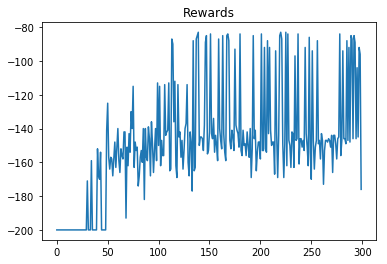

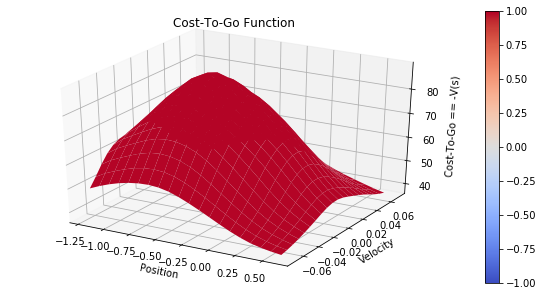

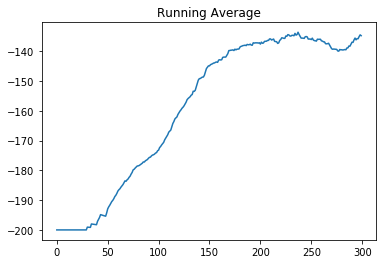

In [7]:
env=gym.make('MountainCar-v0')
ft = FeatureTransformer(env)
model = Model(env,ft,"constant")

gamma = 0.99

filename = "rbfnetwork_mtncar"
monitor_dir ="./" + filename + "_" + str(datetime.now().date())
if monitor_dir[2:] not in os.listdir():
    os.mkdir(monitor_dir)  
env = wrappers.Monitor(env,monitor_dir,force=True)

N = 300
totalrewards = np.empty(N)

for n in range(N):
    eps = 0.1*(0.97**n)
    totalreward = play_one(model,eps,gamma)
    totalrewards[n] = totalreward
    print("episode:",n, "total_reward:", totalreward)
    

print("avg rewards for last 100 episodes:", totalrewards[-100:].mean())
print("total steps:", totalrewards.sum())

plt.plot(totalrewards)
plt.title("Rewards")
plt.show()
plot_cost_to_go(env,model)
plot_running_avg(totalrewards)
env.close()

In [8]:
env = gym.make('MountainCar-v0')
filename = "rbfnet_mtncar_result"
monitor_dir ="./" + filename + "_" + str(datetime.now().date())
if monitor_dir[2:] not in os.listdir():
    os.mkdir(monitor_dir)
env = wrappers.Monitor(env,monitor_dir,force=True)
print("Rewards: ",play_one(model,eps=0,gamma = 0.99))
env.close()

Rewards:  -86.0


## RBF for CartPole

In [9]:
class SGDRegressor:
    #Making our own SGD class
    def __init__(self,D):
        #Initializing the random weights
        self.w = np.random.randn(D)/np.sqrt(D)
        self.lr = 10e-2
        
    def partial_fit(self,X,Y):
        self.w += self.lr * (Y-X.dot(self.w)).dot(X)
        
    def predict(self,X):
        return X.dot(self.w)

class FeatureTransformer:
    def __init__(self,env):
        #Getting random 10000 samples for the state space for the dummy
        observation_example = np.random.random((20000,4))*2 - 2
        #Scaling the observation space
        scaler = StandardScaler()
        scaler.fit(observation_example)
        
        #Creating the Union of features with different parzen's windows
        featurizer = FeatureUnion([
            ("kernel1",RBFSampler(gamma=0.05, n_components=1000)),
            ("kernel2",RBFSampler(gamma=1.0, n_components=1000)),
            ("kernel3",RBFSampler(gamma=0.5, n_components=1000)),
            ("kernel4",RBFSampler(gamma=0.1, n_components=1000))
        ])
        
        
        #Fitting the state-to-feature converter
        feature_examples = featurizer.fit_transform(scaler.transform(observation_example))
        self.dimensions = feature_examples.shape[1]
        self.scaler = scaler
        self.featurizer = featurizer
    
    def transform(self,observations):
        scaled = self.scaler.transform(observations)
        return self.featurizer.transform(scaled)
    

class Model:
    
    def __init__(self, env, feature_transformer):
        self.env = env
        #This will be a collection of multiple models, one for each action
        self.models = []
        self.feature_transformer = feature_transformer
        
        for i in range(env.action_space.n):
            model = SGDRegressor(feature_transformer.dimensions)
            self.models.append(model)
            
    def predict(self,s):
        '''To transform a state and get a prediction form the model'''
        X = self.feature_transformer.transform(np.atleast_2d(s))
        #Getting the prediction/proba for each action
        return np.array([m.predict(X)[0] for m in self.models])
    
    def update(self,s,a,G):
        '''For the Model Updates'''
        X  = self.feature_transformer.transform(np.atleast_2d(s))
        #Fitting the model to predict the return
        self.models[a].partial_fit(X,[G])
    
    def sample_action(self,s,eps):
        #To perform the epsilon greedy action selection
        if np.random.random()<eps:
            return self.env.action_space.sample()
        else:
            #Greedy action
            return np.argmax(self.predict(s))

In [10]:
def play_one(env, model, eps, gamma):
    observation = env.reset()
    done = False
    totalreward = 0
    
    iters = 0 
    
    while not done:
        action = model.sample_action(observation,eps)
        prev_observation = observation
        observation,reward,done,_ = env.step(action)
        
        
        if done:
            reward = -200
            
        #Calculating returns according to the 
        G = reward + gamma*np.max(model.predict(observation))
        model.update(prev_observation,action,G)
        
        if reward == 1:
            totalreward += reward
        iters += 1
        
    return totalreward

def plot_running_avg(totalreward):
    N = len(totalreward)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalreward[max(0,t-100):(t+1)].mean()
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()

In [11]:
gym.envs.register(
    id='CartPole-v2',
    entry_point='gym.envs.classic_control:CartPoleEnv',
    tags={'wrapper_config.TimeLimit.max_episode_steps': 2500},
    reward_threshold=2500.0,
)

Error: Cannot re-register id: CartPole-v2

In [12]:
env=gym.make('CartPole-v2')
ft = FeatureTransformer(env)
model = Model(env,ft)
gamma = 0.99

In [16]:
env=gym.make('CartPole-v2')

filename = "rbfnetwork_cartpole"
monitor_dir ="./" + filename + "_" + str(datetime.now().date())
if monitor_dir[2:] not in os.listdir():
    os.mkdir(monitor_dir)  
env = wrappers.Monitor(env,monitor_dir,force=True)

N = 100
totalrewards = np.empty(N)

for n in range(N):
    eps = 0.1*(0.97**n)
    totalreward = play_one(env,model,eps,gamma)
    totalrewards[n] = totalreward
    print("episode:",n, "total_reward:", totalreward)
    

print("avg rewards for last 100 episodes:", totalrewards[-100:].mean())
print("total steps:", totalrewards.sum())

plt.plot(totalrewards)
plt.title("Rewards")
plt.show()
plot_running_avg(totalrewards)
env.close()

episode: 0 total_reward: 182.0
episode: 1 total_reward: 243.0
episode: 2 total_reward: 339.0
episode: 3 total_reward: 291.0
episode: 4 total_reward: 321.0
episode: 5 total_reward: 303.0
episode: 6 total_reward: 432.0
episode: 7 total_reward: 309.0
episode: 8 total_reward: 231.0
episode: 9 total_reward: 225.0
episode: 10 total_reward: 248.0
episode: 11 total_reward: 257.0
episode: 12 total_reward: 254.0
episode: 13 total_reward: 278.0
episode: 14 total_reward: 327.0
episode: 15 total_reward: 259.0
episode: 16 total_reward: 274.0
episode: 17 total_reward: 347.0
episode: 18 total_reward: 309.0
episode: 19 total_reward: 333.0
episode: 20 total_reward: 303.0
episode: 21 total_reward: 303.0
episode: 22 total_reward: 392.0
episode: 23 total_reward: 339.0
episode: 24 total_reward: 353.0
episode: 25 total_reward: 399.0
episode: 26 total_reward: 404.0
episode: 27 total_reward: 345.0
episode: 28 total_reward: 474.0
episode: 29 total_reward: 347.0
episode: 30 total_reward: 620.0
episode: 31 total_

KeyboardInterrupt: 

In [21]:
env = gym.make('CartPole-v0')
filename = "rbfnet_cartpole_result"
monitor_dir ="./" + filename + "_" + str(datetime.now().date())
if monitor_dir[2:] not in os.listdir():
    os.mkdir(monitor_dir)
env = wrappers.Monitor(env,monitor_dir,force=True)
print("Rewards: ",play_one(env,model,eps=0,gamma = 0.99))
env.close()

Rewards:  199.0


## Neural Nets 

In [8]:
class SGDRegressor:
    #Making our own SGD class
    def __init__(self,D):
        #Initializing the random weights
        self.w = tf.Variable(tf.random_normal(shape=(D,1),name='w'))
        self.X = tf.placeholder(tf.float32,shape=(None,D),name="X")
        self.Y = tf.placeholder(tf.float32, shape=(None,),name="Y")
        
        Y_hat = tf.reshape(tf.matmul(self.X,self.w),[-1])
        delta = self.Y - Y_hat
        #Mean Squared error
        cost = tf.reduce_sum(delta*delta)
        
        #Training 
        self.train = tf.train.GradientDescentOptimizer(10e-2).minimize(cost)
        self.predict_op = Y_hat
        
        init = tf.global_variables_initializer()
        self.session = tf.InteractiveSession()
        self.session.run(init)
        
    def partial_fit(self,X,Y):
        self.session.run(self.train,feed_dict={self.X:X,self.Y:Y})
    def predict(self,X):
        return self.session.run(self.predict_op,feed_dict={self.X:X})
    
class FeatureTransformer:
    def __init__(self,env):
        #Getting random 10000 samples for the state space for the dummy
        observation_example = np.random.random((20000,4))*2 - 2
        #Scaling the observation space
        scaler = StandardScaler()
        scaler.fit(observation_example)
        
        #Creating the Union of features with different parzen's windows
        featurizer = FeatureUnion([
            ("kernel1",RBFSampler(gamma=0.05, n_components=1000)),
            ("kernel2",RBFSampler(gamma=1.0, n_components=1000)),
            ("kernel3",RBFSampler(gamma=0.5, n_components=1000)),
            ("kernel4",RBFSampler(gamma=0.1, n_components=1000))
        ])
        
        
        #Fitting the state-to-feature converter
        feature_examples = featurizer.fit_transform(scaler.transform(observation_example))
        self.dimensions = feature_examples.shape[1]
        self.scaler = scaler
        self.featurizer = featurizer
    
    def transform(self,observations):
        scaled = self.scaler.transform(observations)
        return self.featurizer.transform(scaled)
    

class Model:
    
    def __init__(self, env, feature_transformer):
        self.env = env
        #This will be a collection of multiple models, one for each action
        self.models = []
        self.feature_transformer = feature_transformer
        
        for i in range(env.action_space.n):
            model = SGDRegressor(feature_transformer.dimensions)
            self.models.append(model)
            
    def predict(self,s):
        '''To transform a state and get a prediction form the model'''
        X = self.feature_transformer.transform(np.atleast_2d(s))
        #Getting the prediction/proba for each action
        return np.array([m.predict(X)[0] for m in self.models])
    
    def update(self,s,a,G):
        '''For the Model Updates'''
        X  = self.feature_transformer.transform(np.atleast_2d(s))
        #Fitting the model to predict the return
        self.models[a].partial_fit(X,[G])
    
    def sample_action(self,s,eps):
        #To perform the epsilon greedy action selection
        if np.random.random()<eps:
            return self.env.action_space.sample()
        else:
            #Greedy action
            return np.argmax(self.predict(s))

In [9]:
def play_one(env, model, eps, gamma):
    
    observation = env.reset()
    done = False
    totalreward = 0
    
    iters = 0 
    
    while not done and iters<5000:
        action = model.sample_action(observation,eps)
        prev_observation = observation
        observation,reward,done,_ = env.step(action)
        
        
        if done:
            reward = -200
            
        #Calculating returns according to the 
        G = reward + gamma*np.max(model.predict(observation))
        model.update(prev_observation,action,G)
        
        if reward == 1:
            totalreward += reward
        iters += 1
        
    return totalreward

def plot_running_avg(totalreward):
    N = len(totalreward)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalreward[max(0,t-100):(t+1)].mean()
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()

In [4]:
gym.envs.register(
    id='CartPole-v3',
    entry_point='gym.envs.classic_control:CartPoleEnv',
    tags={'wrapper_config.TimeLimit.max_episode_steps': 5000},
    reward_threshold=4750.0,
)

In [10]:
env=gym.make('CartPole-v3')
ft = FeatureTransformer(env)
model = Model(env,ft)
gamma = 0.99

C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [13]:
env=gym.make('CartPole-v3')

N = 200
totalrewards = np.empty(N)

for n in range(N):
    eps = 1.0/np.sqrt(n+1)
    totalreward = play_one(env,model,eps,gamma)
    totalrewards[n] = totalreward
    print("episode:",n, "total_reward:", totalreward)
    

print("avg rewards for last 100 episodes:", totalrewards[-100:].mean())
print("total steps:", totalrewards.sum())

plt.plot(totalrewards)
plt.title("Rewards")
plt.show()
plot_running_avg(totalrewards)
env.close()

episode: 0 total_reward: 36.0
episode: 1 total_reward: 9.0
episode: 2 total_reward: 34.0
episode: 3 total_reward: 191.0
episode: 4 total_reward: 47.0
episode: 5 total_reward: 185.0
episode: 6 total_reward: 99.0
episode: 7 total_reward: 131.0
episode: 8 total_reward: 21.0
episode: 9 total_reward: 20.0
episode: 10 total_reward: 164.0
episode: 11 total_reward: 219.0
episode: 12 total_reward: 139.0
episode: 13 total_reward: 162.0
episode: 14 total_reward: 465.0
episode: 15 total_reward: 35.0
episode: 16 total_reward: 80.0
episode: 17 total_reward: 281.0
episode: 18 total_reward: 132.0
episode: 19 total_reward: 13.0
episode: 20 total_reward: 69.0
episode: 21 total_reward: 39.0
episode: 22 total_reward: 172.0
episode: 23 total_reward: 581.0
episode: 24 total_reward: 31.0
episode: 25 total_reward: 323.0
episode: 26 total_reward: 185.0
episode: 27 total_reward: 68.0
episode: 28 total_reward: 222.0
episode: 29 total_reward: 261.0
episode: 30 total_reward: 251.0
episode: 31 total_reward: 13.0
ep

KeyboardInterrupt: 

In [14]:
env = gym.make('CartPole-v3')
filename = "neuralnet_cartpole_result"
monitor_dir ="./" + filename + "_" + str(datetime.now().date())
if monitor_dir[2:] not in os.listdir():
    os.mkdir(monitor_dir)
env = wrappers.Monitor(env,monitor_dir,force=True)
print("Rewards: ",play_one(env,model,eps=0,gamma = 0.99))
env.close()

Rewards:  5000.0
